In [1]:
from fastai.vision.all import *
import pdb
from numba import jit

In [2]:
#use cuda if avaliable, otherwise use cpu --- Not recomended to use CPU it will take a looooong time
device = 'cuda' if torch.cuda.is_available else 'cpu'
defaults.device = torch.device(device)

In [3]:
#load data | file names and landmarks
neuro_list = pd.read_csv("../data/TorontoNeuroFace_cropped_Landmarks.csv", index_col = 0)

#this are the test subjects. Test subjects were randomly selected, you can adjust this to your linking
test_subjects = list(pd.read_csv("../data/test_subjects.txt", index_col=0).Test_Subjects.values)


#test data frame
neuro_list_test = neuro_list[neuro_list['subject_id'].isin(test_subjects)]
#train + val data frame
neuro_list_train_val = neuro_list[~neuro_list['subject_id'].isin(test_subjects)]

#spit train and validation sets and add a column to indicate the group. Val subjects were randomly selected, you can adjust this to your linking
val_subjects = list(pd.read_csv("../data/val_subjects.txt", index_col=0).Val_Subjects.values)
neuro_list_train = neuro_list_train_val[~neuro_list_train_val['subject_id'].isin(val_subjects)].reset_index(drop=True)
neuro_list_train['is_valid'] = 0
neuro_list_val = neuro_list_train_val[neuro_list_train_val['subject_id'].isin(val_subjects)].reset_index(drop=True)
neuro_list_val['is_valid'] = 1
#merge train and val groups 
df = pd.concat([neuro_list_train, neuro_list_val])

cols = list(neuro_list.columns[4:])

In [4]:
#helper function to show results
#adjust the show functions so that you can see the images + landmarks
@typedispatch
def show_batch(x:TensorImage, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    #pdb.set_trace()
    for i,ctx in enumerate(ctxs): 
        x[i].show(ctx=ctx)   
        _descale(y[-1][i],256).show(ctx=ctx)

def show_the_results(x, y, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, stats = None):
    ncols = 2
    n = min(len(x[0]), max_n)
    if ctxs is None: ctxs = get_grid(ncols * n, nrows=nrows, ncols=ncols, 
                                     figsize=figsize, title='Target/Prediction')

    points, _,_  = get_preds_fromhm(y.detach().cpu().numpy())
    pp = TensorPoint(points*4)
    #pdb.set_trace()
    if stats is None:
        stats = imagenet_stats
    for tctx,pctx,j in zip(ctxs[0::ncols], ctxs[1::ncols], range(n)):
        #
        img = x[0][j]
        img.show(ctx=tctx)
        _descale(x[1][1][j],256).cpu().show(ctx=tctx)
        img.show(ctx=pctx)
        pp[j].show(ctx=pctx)
        


In [5]:
#helper functions to translate heatmaps into (x,y) coordinates
#these were taken/ adpted from
# - https://github.com/1adrianb/face-alignment/
@jit(nopython=True)
def transform_np(point, center, scale, resolution, invert=False):
    """Generate and affine transformation matrix.
    Given a set of points, a center, a scale and a targer resolution, the
    function generates and affine transformation matrix. If invert is ``True``
    it will produce the inverse transformation.
    Arguments:
        point {numpy.array} -- the input 2D point
        center {numpy.array} -- the center around which to perform the transformations
        scale {float} -- the scale of the face/object
        resolution {float} -- the output resolution
    Keyword Arguments:
        invert {bool} -- define wherever the function should produce the direct or the
        inverse transformation matrix (default: {False})
    """
    _pt = np.ones(3)
    _pt[0] = point[0]
    _pt[1] = point[1]

    h = 200.0 * scale
    t = np.eye(3)
    t[0, 0] = resolution / h
    t[1, 1] = resolution / h
    t[0, 2] = resolution * (-center[0] / h + 0.5)
    t[1, 2] = resolution * (-center[1] / h + 0.5)

    if invert:
        t = np.ascontiguousarray(np.linalg.pinv(t))

    new_point = np.dot(t, _pt)[0:2]

    return new_point.astype(np.int32)


def get_preds_fromhm(hm, center=None, scale=None):
    """Obtain (x,y) coordinates given a set of N heatmaps. If the center
    and the scale is provided the function will return the points also in
    the original coordinate frame.
    Arguments:
        hm {torch.tensor} -- the predicted heatmaps, of shape [B, N, W, H]
    Keyword Arguments:
        center {torch.tensor} -- the center of the bounding box (default: {None})
        scale {float} -- face scale (default: {None})
    """
    B, C, H, W = hm.shape
    hm_reshape = hm.reshape(B, C, H * W)
    idx = np.argmax(hm_reshape, axis=-1)
    scores = np.take_along_axis(hm_reshape, np.expand_dims(idx, axis=-1), axis=-1).squeeze(-1)
    preds, preds_orig = _get_preds_fromhm(hm, idx, center, scale)

    return preds, preds_orig, scores


@jit(nopython=True)
def _get_preds_fromhm(hm, idx, center=None, scale=None):
    """Obtain (x,y) coordinates given a set of N heatmaps and the
    coresponding locations of the maximums. If the center
    and the scale is provided the function will return the points also in
    the original coordinate frame.
    Arguments:
        hm {torch.tensor} -- the predicted heatmaps, of shape [B, N, W, H]
    Keyword Arguments:
        center {torch.tensor} -- the center of the bounding box (default: {None})
        scale {float} -- face scale (default: {None})
    """
    B, C, H, W = hm.shape
    idx += 1
    preds = idx.repeat(2).reshape(B, C, 2).astype(np.float32)
    preds[:, :, 0] = (preds[:, :, 0] - 1) % W + 1
    preds[:, :, 1] = np.floor((preds[:, :, 1] - 1) / H) + 1

    for i in range(B):
        for j in range(C):
            hm_ = hm[i, j, :]
            pX, pY = int(preds[i, j, 0]) - 1, int(preds[i, j, 1]) - 1
            if pX > 0 and pX < 63 and pY > 0 and pY < 63:
                diff = np.array(
                    [hm_[pY, pX + 1] - hm_[pY, pX - 1],
                     hm_[pY + 1, pX] - hm_[pY - 1, pX]])
                preds[i, j] += np.sign(diff) * 0.25

    preds -= 0.5

    preds_orig = np.zeros_like(preds)
    if center is not None and scale is not None:
        for i in range(B):
            for j in range(C):
                preds_orig[i, j] = transform_np(
                    preds[i, j], center, scale, H, True)

    return preds, preds_orig


In [176]:
# #this is the original way (from face-alignment github) used to create heatmaps. 
# #however it is too slow (at least six times slower than the method that i'm using )

# #I'm leaving this here for information purposes only. I'm not using this code to generate the heatmaps

# #helper functions to create heatmaps 
# #these were taken/ adpted from
# # - https://github.com/TaatiTeam/orofacial
# # - https://github.com/1adrianb/face-alignment/
# def _gaussian_fast(size=3, sigma=0.25, amplitude=1., offset=[0., 0.], device='cpu'):
#     coordinates = torch.stack(torch.meshgrid(torch.arange(-size // 2 + 1. -offset[0], size // 2 + 1. -offset[0], step=1),
#                                    torch.arange(-size // 2 + 1. -offset[1], size // 2 + 1. -offset[1], step=1))).to(device)
#     coordinates = coordinates / (sigma * size)
#     gauss = amplitude * torch.exp(-(coordinates**2 / 2).sum(dim=0))
#     return gauss.permute(1, 0)

# def draw_gaussian(image, point, sigma, offset=False):
#     # Check if the gaussian is inside
#     ul = [math.floor(point[0] - 3 * sigma), math.floor(point[1] - 3 * sigma)]
#     br = [math.floor(point[0] + 3 * sigma), math.floor(point[1] + 3 * sigma)]
#     if (ul[0] > image.shape[1] or ul[1] > image.shape[0] or br[0] < 1 or br[1] < 1):
#         return image
#     size = 6 * sigma + 1
#     # g = torch.Tensor(_gaussian(size, offset=point%1) if offset else _gaussian(size), device=image.device)
#     g = _gaussian_fast(size, offset=point%1, device=image.device) if offset else _gaussian_fast(size, device=image.device)
#     g_x = [int(max(1, -ul[0])), int(min(br[0], image.shape[1])) - int(max(1, ul[0])) + int(max(1, -ul[0]))]
#     g_y = [int(max(1, -ul[1])), int(min(br[1], image.shape[0])) - int(max(1, ul[1])) + int(max(1, -ul[1]))]
#     img_x = [int(max(1, ul[0])), int(min(br[0], image.shape[1]))]
#     img_y = [int(max(1, ul[1])), int(min(br[1], image.shape[0]))]
#     assert (g_x[0] > 0 and g_y[1] > 0)
#     image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]
#           ] = image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]] + g[g_y[0] - 1:g_y[1], g_x[0] - 1:g_x[1]]
#     image[image > 1] = 1
#     return image

# def create_target_heatmap(target_landmarks, centers, scales):
#     heatmaps = torch.zeros((target_landmarks.shape[0], 68, 64, 64)).type(torch.FloatTensor)
#     for i in range(heatmaps.shape[0]):
#         for p in range(68):
#             landmark_cropped_coor = transform(target_landmarks[i, p] + 1, centers[i], scales[i], 64, invert=False)
#             heatmaps[i, p] = draw_gaussian(heatmaps[i, p], landmark_cropped_coor + 1, 2)
#     return heatmaps

# def find_boundingbox(target_landmarks, reference_scale = 195):
    
#     max_xy,_ = target_landmarks.max(dim=1)
#     min_xy,_ = target_landmarks.min(dim=1)
#     d = torch.cat([min_xy,max_xy], dim=1)
    
#     center = torch.cat(((d[:,2] - (d[:,2] - d[:,0]) / 2.0).view(-1,1),  (d[:,3] - (d[:,3] - d[:,1]) / 2.0).view(-1,1)), dim=1)
#     center[:,1] = center[:,1] - (d[:,3] - d[:,1]) * 0.12
#     scale = (d[:,2] - d[:,0] + d[:,3] - d[:,1]) / 195
    
#     return center, scale

# #these functions will take a set of landmarks (TensorPoint in FastAI) and generate a heatmap 
# #heatmap production is the same as SBR code to keep everything consisten

# def _scale(p, s): return 2 * (p / s) - 1
# def _descale(p, s): return (0.5*(p+1.))*s 

# def heatmap2argmax(heatmap, scale=False):
#     if len(heatmap.shape)<4:
#         heatmap = heatmap.unsqueeze(0)

#     N, C, H, W = heatmap.shape
#     index = heatmap.view(N,C,1,-1).argmax(dim=-1)
#     pts = torch.cat([index%W, index//W], dim=2)
    
#     if scale:
#         scale = tensor([W,H], device=heatmap.device)
#         pts = _scale(pts, scale)
    
#     return pts

# class Heatmap(TensorImageBase): 
#     "Heatmap tensor, we can use the type to modify how we display things"
#     pass

# class HeatmapPoint(TensorPoint):
#     """
#     A class that mimics TensorPoint, but wraps it so
#     we'll be able to override `show` methods with
#     a different type.
#     """
#     pass

# class HeatmapTransform(Transform):
#     """
#     A batch transform that turns TensorPoint instances into Heatmap instances,
#     and Heatmap instances into HeatmapPoint instances.
    
#     Used as the last transform after all other transformations. 
#     """
#     # We want the heat map transformation to happen last, so give it a high order value
#     order=999
    
#     def __init__(self, image_size,**kwargs):
#         """
#         heatmap_size: Size of the heatmap to be created
#         sigma: Standard deviation of the Gaussian kernel
#         """
#         super().__init__(**kwargs)
#         self.size = image_size

    
#     def encodes(self, x:TensorPoint):
#         # The shape of x is (batch x n_points x 2)
#         num_imgs = x.shape[0]
#         num_points = x.shape[1]
        
#         #x are landmarks between -1 and 1 
#         points =_descale(x, self.size)
#         centers, scales = find_boundingbox(points)
#         Heatmaps = create_target_heatmap(points, centers, scales)
            
#         HM= Heatmaps.type(torch.FloatTensor).to(x.device)

#         #pdb.set_trace()
#         return HM, x
    
#     def decodes(self, x:Heatmap):
#         """
#         Decodes a heat map back into a set of points by finding
#         the coordinates of their argmax.
        
#         This returns a HeatmapPoint class rather than a TensorPoint
#         class, so we can modify how we display the output.
#         """
       
#         pp,_ = get_preds_fromhm(x.detach().cpu().numpy())
#         xy = _scale(pp*4,self.size)
#         return HeatmapPoint(xy, source_heatmap=x)
    


In [6]:
#generate heatmaps 
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

#scale and descale helpers
def _scale(p, s): return 2 * (p / s) - 1
def _descale(p, s): return (0.5*(p+1.))*s 

class Heatmap(TensorImageBase): 
    "Heatmap tensor, we can use the type to modify how we display things"
    pass

class HeatmapPoint(TensorPoint):
    """
    A class that mimics TensorPoint, but wraps it so
    we'll be able to override `show` methods with
    a different type.
    """
    pass

class HeatmapTransform(Transform):
    """
    A batch transform that turns TensorPoint instances into Heatmap instances,
    and Heatmap instances into HeatmapPoint instances.
    
    Used as the last transform after all other transformations. 
    """
    # We want the heat map transformation to happen last, so give it a high order value
    order=999
    
    def __init__(self, heatmap_size, sigma=5, **kwargs):
        """
        heatmap_size: Size of the heatmap to be created
        sigma: Standard deviation of the Gaussian kernel
        """
        super().__init__(**kwargs)
        self.sigma = sigma
        self.size = heatmap_size
    
    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]
        maps = np.zeros((num_imgs, num_points, *self.size), dtype = float)
        #M = np.zeros((num_imgs, num_points, *self.size), dtype = float)
        for b in range(num_imgs):
            rows = x[b][:]
            mu_x = (0.5 * (rows[:,0] + 1.) * self.size[0]).int()
            mu_y = (0.5 * (rows[:,1] + 1.) * self.size[1]).int()
            for c in range(num_points):
                maps[b][c] = draw_umich_gaussian(maps[b][c], [mu_x[c], mu_y[c]], self.sigma)
                #M[b][c] = grey_dilation(maps[b][c], size=(3,3))
                #M[b][c] = np.where(M[b][c]>=0.5,1,0)  #in the paper it says 0.2 instead of 0.5

        return Heatmap(torch.tensor(maps)).to(x.device), x
    
    def decodes(self, x:Heatmap):
        """
        Decodes a heat map back into a set of points by finding
        the coordinates of their argmax.
        
        This returns a HeatmapPoint class rather than a TensorPoint
        class, so we can modify how we display the output.
        """
       
        # Flatten the points along the final axis,
        # and find the argmax per channel
        pp,_,scores = get_preds_fromhm(x.detach().cpu().numpy())
        xy = _scale(pp*4,self.size)
        return HeatmapPoint(xy, source_heatmap=x)

In [7]:
#Generate a FastAI datablock that gets an image and landmarks and returns:
# - Image (normalized with Imagenet Stats)
# - Heatmaps
# - Mask
# - Ground Truth landmarks

# Some random transformations that are applied to the images include:
# - Random rotation (-10 to +10 deg)
# - Random zoom (-0.9 to 1.15)
# See FastAI for other transformations 

def get_x(x) : 
    return Path('../data/cropped')/x['file_name']

def get_y(x):
    
    val = x[cols].values
    points = torch.from_numpy(np.array(val, dtype=np.float)).view(-1,2)
    return points

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    splitter= ColSplitter('is_valid'),
    get_x = get_x,
    get_y = get_y,
    #item_tfms = Resize((400,400)),
    batch_tfms = [*aug_transforms(size=(256,256),do_flip=False, min_zoom = 0.9, max_zoom = 1.15, max_warp=0, pad_mode='zeros'), 
                  #Normalize.from_stats(*imagenet_stats),
                  #TensorNormalize(),
                  #HeatmapTransform(image_size=256),
                  HeatmapTransform(heatmap_size=(64,64))
                 ]
    )

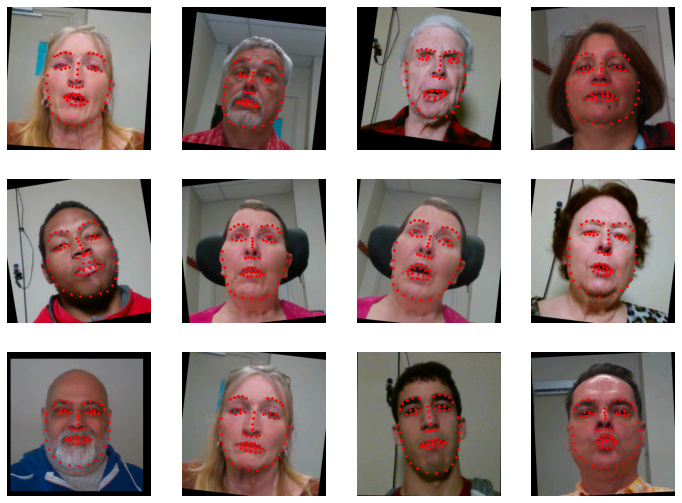

In [8]:
#show one batch of the training set
dls = dblock.dataloaders(df, num_workers=0, bs = 24)
dls.show_batch(max_n=12)

In [9]:
#create a test dataloader with labels
test_dl = dls.test_dl(neuro_list_test, with_labels=True)


In [10]:
#load Pretrained FAN model
#download from here - https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip
faceAlignmentModel = torch.jit.load('../pretrained_models/2DFAN4-cd938726ad.zip')
faceAlignmentModel.to(device);

In [11]:
class WingLoss(nn.Module):
    """
    https://arxiv.org/pdf/1711.06753.pdf
    Refactored implementation from  https://github.com/BloodAxe/pytorch-toolbelt/.
    Supports intermediate supervision.
    """
    def __init__(self, width=5, curvature=0.5):
        super(WingLoss, self).__init__()
        self.w = width
        self.curvature = curvature
        self.c = self.w - self.w * math.log(1 + self.w / self.curvature)

    def __forward_single(self, preds, target):
        preds = TensorBase(preds) #convert tensorImage to tensor 
        target = TensorBase(target) #convert tensorImage to tensor 
        diff_abs = (target - preds).abs()
        loss = diff_abs.clone()

        idx_smaller = diff_abs < self.w
        idx_bigger = diff_abs >= self.w

        loss[idx_smaller] = self.w * torch.log(1 + diff_abs[idx_smaller] / self.curvature)
        loss[idx_bigger] = loss[idx_bigger] - self.c

        return loss.mean()

    def forward(self, preds, target):
        loss = 0
        
        preds = preds[1]

        if not isinstance(preds, tuple):
            preds = (preds,)

        for i in range(len(preds)):
            loss += self.__forward_single(preds[i], target)

        return loss
    
#We will use the WingLoss as loss function 
#https://openaccess.thecvf.com/content_ICCV_2019/papers/Wang_Adaptive_Wing_Loss_for_Robust_Face_Alignment_via_Heatmap_Regression_ICCV_2019_paper.pdf
class AWing(nn.Module):

    def __init__(self, alpha=2.1, omega=14, epsilon=1, theta=0.5):
        super().__init__()
        self.alpha   = float(alpha)
        self.omega   = float(omega)
        self.epsilon = float(epsilon)
        self.theta   = float(theta)

    def forward(self, y_pred , y):
        lossMat = torch.zeros_like(y_pred)
        A = self.omega * (1/(1+(self.theta/self.epsilon)**(self.alpha-y)))*(self.alpha-y)*((self.theta/self.epsilon)**(self.alpha-y-1))/self.epsilon
        C = self.theta*A - self.omega*torch.log(1+(self.theta/self.epsilon)**(self.alpha-y))
        case1_ind = torch.abs(y-y_pred) < self.theta
        case2_ind = torch.abs(y-y_pred) >= self.theta
        lossMat[case1_ind] = self.omega*torch.log(1+torch.abs((y[case1_ind]-y_pred[case1_ind])/self.epsilon)**(self.alpha-y[case1_ind]))
        lossMat[case2_ind] = A[case2_ind]*torch.abs(y[case2_ind]-y_pred[case2_ind]) - C[case2_ind]
        return lossMat

class Loss_weighted(nn.Module):
    def __init__(self, W=10, alpha=2.1, omega=14, epsilon=1, theta=0.5):
        super().__init__()
        self.W = float(W)
        self.Awing = AWing(alpha, omega, epsilon, theta)

    def forward(self, y_pred , y):
        
        y_pred = TensorBase(y_pred) #these are the heatmaps out of the model
        targs  = TensorBase(y[0]) #These are the manually generated heatmaps
        
        Loss = 0 
        Loss = self.Awing(y_pred,targs)

        return Loss.mean()

In [12]:

def nmae_argmax(preds, target):
    #FastAI resturn an object of type TensorImage (that has a show property). We need to return that into Tensor (TensorBase)
    #also, we need to descale the ground truth landmarks
    points,_, _ = get_preds_fromhm(preds.detach().cpu().numpy())
    return ((TensorBase(points*4)-_descale(TensorBase(target[1].detach().cpu()),256)).abs()).mean()


def Normalized_RMSE(preds, targets, selected=None):
    #compute the Root Mean Squared Error between two sets of landmarks (ground truth and model predictions)
    #works in a batch
    
    pp,_,_=get_preds_fromhm(preds.detach().cpu().numpy())
    pp  = torch.tensor(pp*4)
    #FastAI resturn an object of type TensorImage (that has a show property). We need to return that into Tensor (TensorBase)  
    gt = _descale(TensorBase(targets[1].detach().cpu()),256)

    max_xy,_ = gt.max(dim=1)
    min_xy,_ = gt.min(dim=1)
    diag =  torch.linalg.norm(min_xy-max_xy, dim=1)
    
    if selected:
        gt = gt[:,selected,:]
        pp = pp[:,selected,:]
    nrmse = torch.linalg.norm(gt-pp,dim=2).mean(dim=1).div(diag)*100
    
    return nrmse.mean()
                      

In [13]:
#create the learner
learn = Learner(dls, 
                faceAlignmentModel, 
                loss_func = Loss_weighted(),
                metrics=[nmae_argmax, Normalized_RMSE])

In [14]:
# test current model with test data
preds = learn.get_preds(dl=test_dl)
nrmse_pretrained = Normalized_RMSE(preds[0],preds[1])
print(f'Normalized Error with Pre-trained model is {nrmse_pretrained.item()} %')

Normalized Error with Pre-trained model is 1.7416539192199707 %


Normalized Error with Pre-trained model is 1.8132781982421875 %


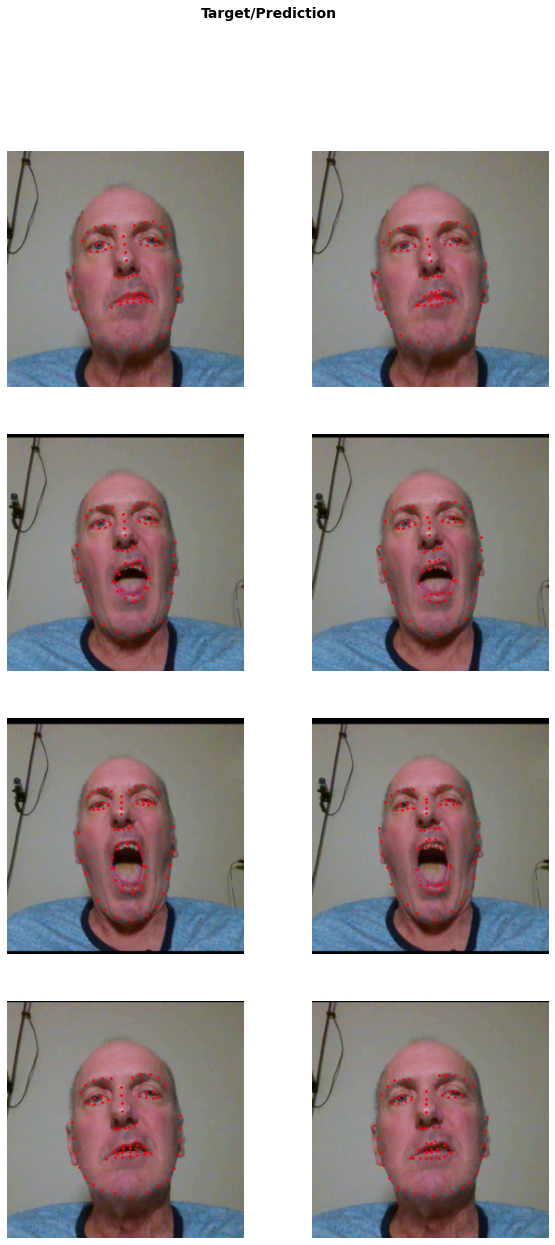

In [15]:
b = dls.valid.one_batch()
f,d,preds = learn.get_preds(dl=[b], with_decoded=True)      
show_the_results(b, preds, max_n=8, figsize=(10,20))
nrmse = Normalized_RMSE(preds, b[1])
print(f'Normalized Error with Pre-trained model is {nrmse.item()} %')

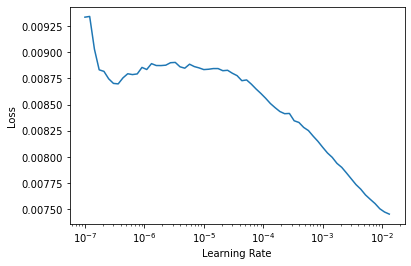

In [17]:
#find learning rate using FastAI 
lr_min, lr_steepest = learn.lr_find()
lr_steepest

In [19]:
#Pick best learning rate from curve and train using FastAI
#Training will include early stoping and saving of best model
Path("./models/models_FAN").mkdir(parents=True, exist_ok=True)
learn.fit_one_cycle(15, slice(lr_steepest), 
                   cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),
                       SaveModelCallback(every_epoch=True, fname='./models_FAN/FineTuned_TorontoNeuroFace_Epoch')],
                   )

epoch,train_loss,valid_loss,nmae_argmax,Normalized_RMSE,time
0,0.007078,0.006103,1.648794,1.476148,01:50
1,0.005851,0.005636,1.533210,1.369578,01:48
2,0.005241,0.005568,1.508219,1.347906,01:48
3,0.004885,0.005459,1.477467,1.321423,01:49
4,0.004683,0.005370,1.452621,1.299772,01:49
5,0.004573,0.005422,1.468632,1.315025,01:49
6,0.004494,0.005379,1.454679,1.302950,01:49
7,0.004396,0.005386,1.455005,1.302631,01:49


No improvement since epoch 4: early stopping


In [20]:
#test new model on testing data
preds = learn.get_preds(dl=test_dl)
nrmse_finetuned = Normalized_RMSE(preds[0],preds[1])
print(f'Test Set - Normalized Error with Pre-trained model is: {nrmse_pretrained.item()} %')
print(f'Test Set - Normalized Error with Fine-tuned model is: {nrmse_finetuned.item()} %')

Test Set - Normalized Error with Pre-trained model is: 1.7416539192199707 %
Test Set - Normalized Error with Fine-tuned model is: 1.3403764963150024 %


Normalized Error with Fine-Tuned model is 1.2512723207473755 %


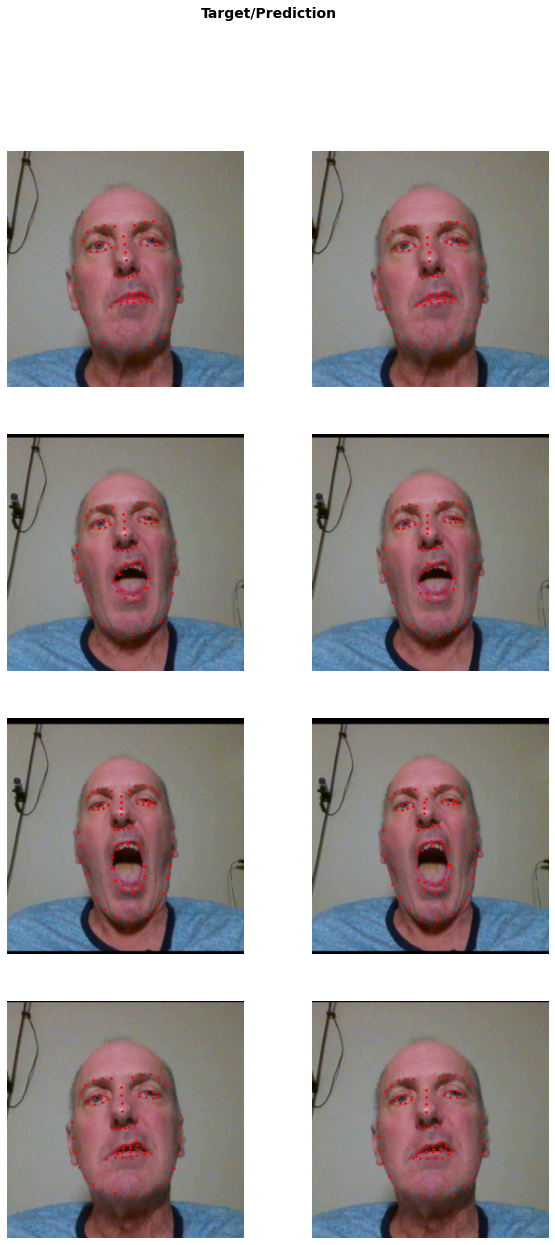

In [21]:
#test a few images from the validation set (showing results)
b = dls.valid.one_batch()
f,d,preds = learn.get_preds(dl=[b], with_decoded=True)
show_the_results(b, preds, max_n=8, figsize=(10,20))
nrmse = Normalized_RMSE(preds, b[1])
print(f'Normalized Error with Fine-Tuned model is {nrmse.item()} %')

## Fin

you can use one of the fine-tuned models as

```python
# Load the pretrained model
faceAlignmentModel = torch.jit.load('../pretrained_models/2DFAN4-cd938726ad.zip')
faceAlignmentModel.load_state_dict(torch.load('./models/models_FAN/FineTuned_TorontoNeuroFace_Epoch_6.pth'))
faceAlignmentModel.to(device);
```